In [8]:
%matplotlib inline

# Word Embedding Clustering

In the previous notebook we have seen how the clustering algorithms behave with a sparse representation based on word coocurrence or in handcrafted features. In this notebook we will evaluate the same results but using representing the words with dense vectors, i.e. word embeddings.

In [1]:
import numpy
import pandas
import seaborn
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import calinski_harabaz_score

## word2vec

In [2]:
from gensim.models import Word2Vec

In [3]:
filename = '/home/mteruel/am/data/wordvectors/echr_word2vec_100.bin.gz'
word_vectors = Word2Vec.load(filename)

The number of words represented in these embeddings is:

In [4]:
word_vectors.syn1.shape[0]

132042

### Visualization

We retrain the same reduction algorithms as before. The TSNE algorithm can't handle the number of embedded words, so we take the first 10000 for visualization.

In [ ]:
svd_reduced_echr_wv = pandas.DataFrame(
    TruncatedSVD(n_components=2).fit_transform(word_vectors.syn1), columns=['x', 'y'])

In [ ]:
tsne_reduced_echr_wv = pandas.DataFrame(
    TSNE(n_components=2, metric='euclidean').fit_transform(word_vectors.syn1[:10000]), columns=['x', 'y'])

### Clustering

#### KMeans

Given the number of embeddigns and their dense nature, we can only train the KMeans algorithm in a reasonable time. First we will estimate the number of clusters to use: we train the KMeans clusterer with each possible number of clusters and then calculate the `calinski_harabaz_score`, a metric used to evaluate the quality of clusters when no true labels are available.

In [29]:
def evaluate_clusters(matrix, cluster_k=[5,10,20,50,100]):
    results = pandas.DataFrame(0, index=cluster_k, columns=['Calinski Harabaz Score'])
    for k in cluster_k:
        clusterer = KMeans(init='k-means++', n_clusters=k, precompute_distances=True)
        clusterer.fit(matrix)
        results.loc[k]['Calinski Harabaz Score'] = calinski_harabaz_score(matrix, clusterer.labels_)
    return results

In [38]:
evaluate_clusters(word_vectors.syn1)

,Calinski Harabaz Score
5,2966
10,1862
20,1132
50,567
100,328


In [ ]:
mbk_echr_wv = KMeans(init='k-means++', n_clusters=10, precompute_distances=True)
kmeans_clusters_echr_wv = mbk_echr_wv.fit_predict(word_vectors.syn1)

In [5]:
# svd_reduced_echr_wv['kmeans_cluster'] = kmeans_clusters_echr_wv
svd_reduced_echr_wv = pandas.read_csv('/home/mteruel/am/data/echr/clusters/svd_reduced_echr_wv.csv')

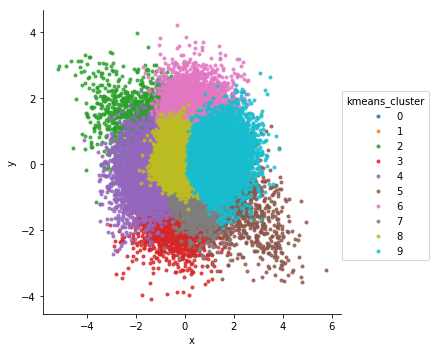

In [6]:
seaborn.lmplot(x='x', y='y', data=svd_reduced_echr_wv, fit_reg=False, hue='kmeans_cluster', markers='.')

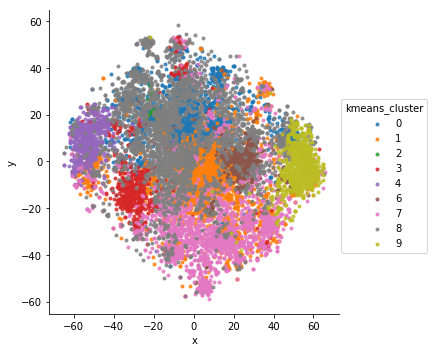

In [7]:
# tsne_reduced_echr_wv['kmeans_cluster'] = kmeans_clusters_echr_wv[:10000]
tsne_reduced_echr_wv = pandas.read_csv('/home/mteruel/am/data/echr/clusters/tsne_reduced_echr_wv.csv')
seaborn.lmplot(x='x', y='y', data=tsne_reduced_echr_wv, fit_reg=False, hue='kmeans_cluster', markers='.')

In [24]:
def sample_clusters_wv(predictions, num_clusters=10, sample_size=15):
    result = pandas.DataFrame(index=range(sample_size))
    for cluster_index in range(num_clusters):
        word_indices = numpy.where(predictions == cluster_index)[0][:sample_size]
        result['Cluster-{}'.format(cluster_index)] = [word_vectors.wv.index2word[i] for i in word_indices]
    return result

In [26]:
sample_clusters_wv(kmeans_clusters_echr_wv)

,Cluster-0,Cluster-1,Cluster-2,Cluster-3,Cluster-4,Cluster-5,Cluster-6,Cluster-7,Cluster-8,Cluster-9
0,as,that,at,its,to,remitting,The,was,the,and
1,Article,Court,points.,three,a,Adlan,on,with,of,by
2,v.,applicant,liability,after,had,Bolotnaya,§,it,in,October
3,Mr,been,harm,considers,which,June.,from,he,for,those
4,court,his,commit,As,there,"restriction,",this,case,be,during
5,judgment,an,Bratza,District,her,"obligations""",no,no.,not,period
6,also,were,mainly,them,2,"blood,",November,their,is,courts
7,are,On,inability,claimed,paragraph,"54071/00,",2.,under,or,European
8,THE,Government,"(ibid.,",persons,present,Kopp,regard,(see,",",This
9,State,against,criticised,basis,him,workers’,Human,Convention,In,having


## Google News wordvectors

In [4]:
from gensim.models.keyedvectors import KeyedVectors
gfilename = '/home/mteruel/am/data/wordvectors/GoogleNews-vectors-negative300.bin.gz'
gword_vectors = KeyedVectors.load_word2vec_format(gfilename, binary=True)

The total number of words in this dataset is:

In [19]:
gword_vectors.syn0.shape[0]

3000000

However, many of these words are not relevant to the legal domain. For a better analysis, we will only take the vectors of words in the intersection between the vocabularies of the two embedding models.

In [5]:
gword_vectors_index = [index for index, word in enumerate(gword_vectors.index2word)
                       if word in word_vectors.wv.vocab]
gword_vectors_filtered = gword_vectors.syn0[gword_vectors_index,:]

The resulting vocabulary has size:

In [6]:
len(gword_vectors_index)

39886

In [ ]:
svd_reduced_g_wv = pandas.DataFrame(
    TruncatedSVD(n_components=2).fit_transform(gword_vectors_filtered), columns=['x', 'y'])

In [ ]:
reduces_g_wv_indices = numpy.random.randint(gword_vectors_filtered.shape[0], size=10000)
tsne_reduced_g_wv = pandas.DataFrame(
    TSNE(n_components=2, metric='euclidean').fit_transform(gword_vectors_filtered[reduces_g_wv_indices,:]),
    columns=['x', 'y'])

In [13]:
mbk_g_wv = KMeans(init='k-means++', n_clusters=10, precompute_distances=True)
kmeans_clusters_g_wv = mbk_g_wv.fit_predict(gword_vectors_filtered)

In [17]:
svd_reduced_g_wv['kmeans_cluster'] = kmeans_clusters_g_wv
svd_reduced_g_wv.to_csv('/home/mteruel/am/data/echr/clusters/svd_reduced_g_wv.csv')

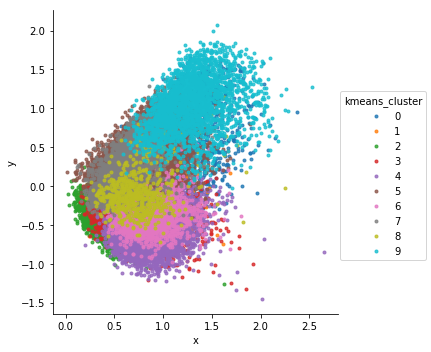

In [16]:
seaborn.lmplot(x='x', y='y', data=svd_reduced_g_wv, fit_reg=False, hue='kmeans_cluster', markers='.')

In [20]:
tsne_reduced_g_wv['kmeans_cluster'] = kmeans_clusters_g_wv[reduces_g_wv_indices]
tsne_reduced_g_wv.to_csv('/home/mteruel/am/data/echr/clusters/tsne_reduced_g_wv.csv')

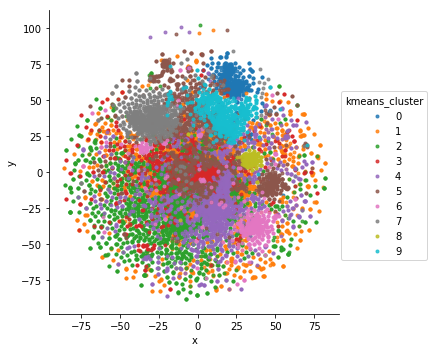

In [22]:
seaborn.lmplot(x='x', y='y', data=tsne_reduced_g_wv, fit_reg=False, hue='kmeans_cluster', markers='.')

In [25]:
sample_clusters_wv(kmeans_clusters_g_wv)

,Cluster-0,Cluster-1,Cluster-2,Cluster-3,Cluster-4,Cluster-5,Cluster-6,Cluster-7,Cluster-8,Cluster-9
0,longer,are,the,13,taken,Protocol,previous,national,about,interpretation
1,simple,6,of,protection,"and,",sentence,later,witness,"incident,",interim
2,instance,right,to,do,applicable,find,"Section),",assistance,spirit,prohibition
3,International,may,and,finding,claims,14.,less,amounts,164.,takes
4,Centre,only,in,official,procedural,served,Bulgaria,presence,frontiers.,art.
5,Sweden,order,that,unlawful,"Accordingly,",hundred,38.,denied,clash,knew
6,2004).,...,a,For,absence,independent,require,released,"fraud,",territorial
7,factor,same,The,Justice,notified,requires,"3,",neither,case.”,II
8,1994.,circumstances,had,cell,obtained,"courts,",close,financial,"long,",110.
9,Counsel,They,on,23.,nor,enforce,earlier,pension,domain,handcuffed


In [30]:
evaluate_clusters(gword_vectors_filtered)

,Calinski Harabaz Score
5,587
10,413
20,277
50,156
100,96


In [41]:
mbk_g_wv5 = KMeans(init='k-means++', n_clusters=5, precompute_distances=True)
kmeans_clusters_g_wv5 = mbk_g_wv5.fit_predict(gword_vectors_filtered)

In [42]:
numpy.unique(kmeans_clusters_g_wv5)

array([0, 1, 2, 3, 4], dtype=int32)

In [43]:
svd_reduced_g_wv['kmeans_cluster5'] = kmeans_clusters_g_wv5
svd_reduced_g_wv.to_csv('/home/mteruel/am/data/echr/clusters/svd_reduced_g_wv.csv')

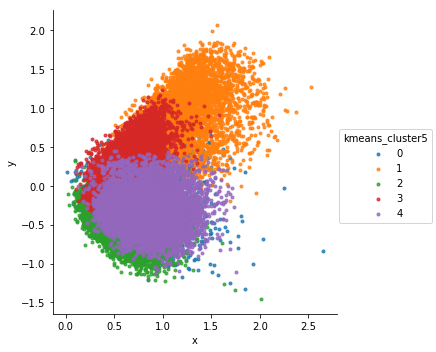

In [44]:
seaborn.lmplot(x='x', y='y', data=svd_reduced_g_wv, fit_reg=False, hue='kmeans_cluster5', markers='.')

In [45]:
tsne_reduced_g_wv['kmeans_cluster5'] = kmeans_clusters_g_wv5[reduces_g_wv_indices]
tsne_reduced_g_wv.to_csv('/home/mteruel/am/data/echr/clusters/tsne_reduced_g_wv.csv')

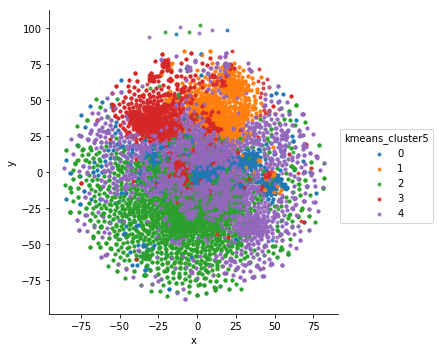

In [46]:
seaborn.lmplot(x='x', y='y', data=tsne_reduced_g_wv, fit_reg=False, hue='kmeans_cluster5', markers='.')

In [48]:
sample_clusters_wv(kmeans_clusters_g_wv5, num_clusters=5)

,Cluster-0,Cluster-1,Cluster-2,Cluster-3,Cluster-4
0,such,served,the,are,6
1,when,interpretation,of,right,present
2,about,enforce,to,same,taken
3,2.,International,and,national,period
4,13,interim,in,Kingdom,European
5,provided,prohibition,that,thus,They
6,Court.,art.,a,requirements,interest
7,Regional,needs,The,victim,(“the
8,non-pecuniary,date.,had,position,costs
9,Protocol,factor,on,detention.,months


## Correlations

## References

Mikolov, Tomas et al. “Efficient Estimation of Word Representations in Vector Space.” CoRR abs/1301.3781 (2013): n. pag.

Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation.

L.J.P. van der Maaten and G.E. Hinton. Visualizing High-Dimensional Data Using t-SNE. Journal of Machine Learning Research